## PyTorch Model

In [1]:
import sys
sys.path.append('../..')
import os
from tqdm import tqdm
from config import client
from pymongo import MongoClient
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from mlpp.data_modeling.preliminary_modeling import get_dataframe
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
osu_db = client['osu_random_db']

## Import Data

In [3]:
df = get_dataframe(osu_db.week_9_sample_users, osu_db.osu_scores_high, osu_db.osu_beatmaps)
df.head()

,count50,count100,count300,countmiss,countgeki,countkatu,perfect,countNormal,countSlider,countSpinner,countTotal,diff_approach,diff_drain,diff_overall,diff_size,hit_length,est_user_pp
0,2,76,133,5,4,20,0,155,60,1,278,5.0,4.0,5.0,5.0,155,114.756841
1,6,24,70,5,14,11,0,79,24,2,133,5.0,5.0,5.0,5.0,64,132.594611
2,2,7,185,1,36,5,0,158,37,0,232,3.0,2.0,3.0,3.0,209,63.021358
3,2,19,230,11,63,11,0,249,12,1,276,4.0,3.0,4.0,5.0,145,61.159836
4,5,41,87,9,38,19,0,92,44,6,198,5.0,5.0,5.0,6.0,129,57.935610


In [19]:
def showCorr():
    correlation = df.astype('float64').corr()
    f, ax = plt.subplots(figsize = (14, 12))
    plt.title("Correlation of Attributes")
    sns.heatmap(correlation, annot = True)
    plt.show()

From this point on, the code is taken from https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

## Create Input and Output Data

In [4]:
X = df.iloc[:, 0:-1] #input
y = df.iloc[:, -1] #output

## Train - Validation - Test

In [5]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=2)

In [6]:
# Normalize input 
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

## Neural Network

In [8]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [9]:
EPOCHS = 250
BATCH_SIZE = 17 
LEARNING_RATE = 0.01
NUM_FEATURES = len(X.columns)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [13]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=16, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


## Train Model

In [14]:
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2500.38916 | Val Loss: 2393.59098
Epoch 002: | Train Loss: 2380.80109 | Val Loss: 2311.45283
Epoch 003: | Train Loss: 2332.48383 | Val Loss: 2292.25872
Epoch 004: | Train Loss: 2312.10177 | Val Loss: 2297.72074
Epoch 005: | Train Loss: 2301.12581 | Val Loss: 2291.72646
Epoch 006: | Train Loss: 2297.39157 | Val Loss: 2288.77033
Epoch 007: | Train Loss: 2288.90327 | Val Loss: 2287.32096
Epoch 008: | Train Loss: 2286.84667 | Val Loss: 2290.97725
Epoch 009: | Train Loss: 2285.16274 | Val Loss: 2339.14165
Epoch 010: | Train Loss: 2277.84510 | Val Loss: 2274.55183
Epoch 011: | Train Loss: 2277.74204 | Val Loss: 2400.40669
Epoch 012: | Train Loss: 2279.00396 | Val Loss: 2274.64207
Epoch 013: | Train Loss: 2275.14724 | Val Loss: 2261.40682
Epoch 014: | Train Loss: 2275.75768 | Val Loss: 2314.23862
Epoch 015: | Train Loss: 2273.16934 | Val Loss: 2322.26198
Epoch 016: | Train Loss: 2270.94588 | Val Loss: 2267.20839
Epoch 017: | Train Loss: 2269.50166 | Val Loss: 2257.013

## Visualize Loss and Accuracy 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

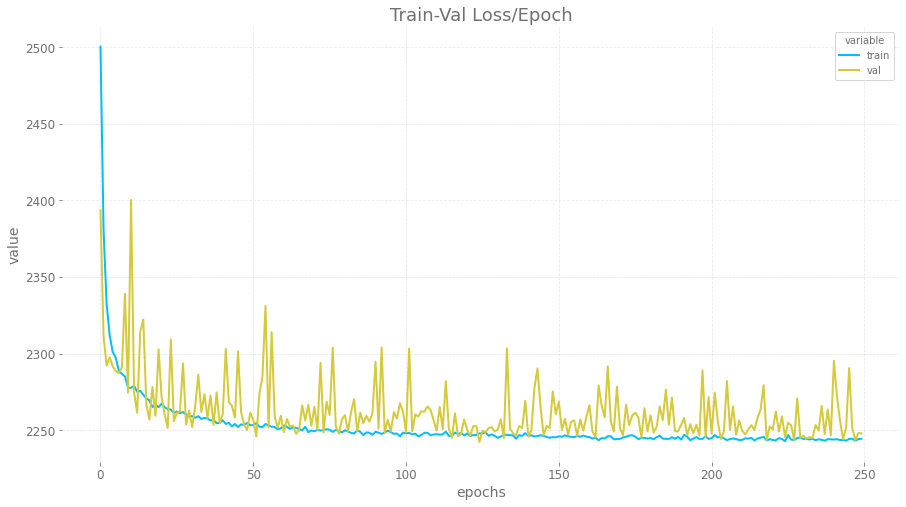

In [16]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

## Test Model

In [17]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred_list))
print("Root Mean Squared Error :", rmse)

Root Mean Squared Error : 46.83656288501654
